In [1]:
%matplotlib inline
from scipy import misc
from scipy.ndimage import gaussian_filter

from skimage.filters import gaussian

from skimage import filters
from PIL import Image
import numpy as np
import cv2
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
#Remaping to 0 - 255 floats
def remap(x):
    minimum = np.amin(x)
    maximum = np.amax(x)
    difference = maximum - minimum
    return ((difference - (maximum - x) ) / difference) * 255

# binarize the image
def binarize(x):
    return np.where(x < filters.threshold_otsu(x), 0, 255)

def remove_background(img, sigma_val):
    result = gaussian_filter(img, sigma=sigma_val)
    return img - result

In [3]:
image = Image.open('raw_exp.bmp')
image_arr = np.array(image)
image_arr.shape 

if image_arr.shape[-1] == 4:
    image_arr = image_arr[:,:,:-1]
    
image_arr = image_arr.astype(float)

image_arr /= 255

# # Crop image Simulation Image
# image_arr = image_arr[100:300, 100:300]

In [4]:
no_bcg = remove_background(image_arr, 30)

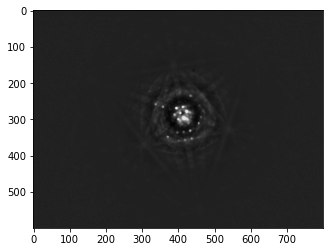

In [5]:
plt.imshow(no_bcg, cmap='gray')

In [18]:
def image_histogram_equalization(image, number_bins=256):

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def local_normalize(images, sigma1, sigma2):
    if len(images.shape)==4:
        for i in range(images.shape[0]):
            
            B=np.zeros_like(images[0,:,:,0])
            S=np.zeros_like(images[0,:,:,0])
            for j in range(images.shape[3]):
                B+=gaussian_filter(images[i,:,:,j],sigma1)
            
            for j in range(images.shape[3]):
                images[i,:,:,j] = images[i,:,:,j] - B/images.shape[3]
            
            for j in range(images.shape[3]):
                S+=np.sqrt(gaussian_filter(images[i,:,:,j]**2, sigma2))
            
            for j in range(images.shape[3]):
                images[i,:,:,j] = images[i,:,:,j] / (S/images.shape[3])
    else:
        images = (images-np.min(images))/(np.max(images)-np.min(images))
        images = images - gaussian(images,sigma1,multichannel=False)
        images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))
        
    return images


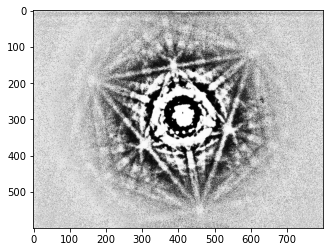

In [7]:
global_norm = image_histogram_equalization(no_bcg)[0]
plt.imshow(global_norm, cmap='gray')

<ipython-input-6-fdaafd0b78b8>:32: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images - gaussian(images,sigma1,multichannel=False)
<ipython-input-6-fdaafd0b78b8>:33: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))


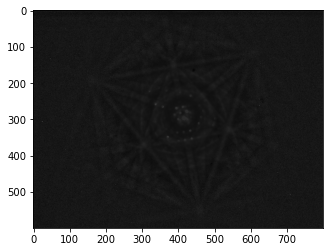

In [10]:
local_norm = local_normalize(no_bcg, 30, 30)
plt.imshow(local_norm, cmap='gray')

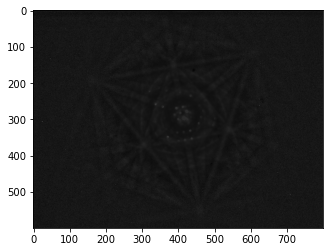

In [12]:
remap_local_norm = remap(local_norm)
plt.imshow(remap_local_norm, cmap='gray')